In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

In [ ]:
import os
import pandas
import spacy

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

from PIL import Image
from torchvision.transforms import transforms

In [ ]:
!pip install https://github.com/explosion/spacy-models/releases/download/ru_core_news_sm-3.1.0/ru_core_news_sm-3.1.0.tar.gz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.9 MB 1.3 MB/s 
     |████████████████████████████████| 5.9 MB 3.7 MB/s 
     |████████████████████████████████| 55 kB 3.8 MB/s 
     |████████████████████████████████| 8.2 MB 39.9 MB/s 
     |████████████████████████████████| 10.1 MB 24.6 MB/s 
     |████████████████████████████████| 660 kB 47.0 MB/s 
  Created wheel for ru-core-news-sm: filename=ru_core_news_sm-3.1.0-py3-none-any.whl size=16086413 sha256=937399a805b7b70901096ae33bf31d423b15357bf259d30de8045ab4332f168b
  Stored in directory: /root/.cache/pip/wheels/98/a7/44/ee07931d9211e738e3b23f0321c9ff7a7ee2ffcad9946a9e07
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13724 sha256=d915224069d9ea52e98beffbf268b77e7a8aff688abafee93a450f9a5aba5352
  Stored in directory: /root/.cache/pip/wheels/72/b0/3f/1d95f96ff986c7dfffe46ce2be4062f38ebd04b506c77c81b9
Successfully bui

In [ ]:
import torch.nn as nn
import torchvision.models as models
import torch

In [ ]:
new_model = models.inception_v3(pretrained=True, aux_logits=True)
new_model.fc

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Linear(in_features=2048, out_features=1000, bias=True)

In [ ]:
class encoderCNN(nn.Module):
    def __init__(self, embed_size, should_train=False):
        super(encoderCNN, self).__init__()
        self.should_train = should_train
        self.inception = models.inception_v3(pretrained=True, aux_logits=True)
        self.inception.fc = nn.Linear(self.inception.fc.in_features, embed_size)
        self.dropout= nn.Dropout(0.5)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        features = self.inception(x)
        
        for name, param in self.inception.named_parameters():
            param.requires_grad = False
        
#         for name, param in self.inception.named_parameters():
#             if "fc.weight" in name or "fc.bias" in name:
#                 param.requires_grad = True
#             else:
#                 param.required_grad = self.should_train
        
        
        return self.dropout(self.relu(features[0]))

In [ ]:
class decoderRNN(nn.Module):
    def __init__(self, embed_size,vocab_size, hidden_size, num_layers):
        super(decoderRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, features, caption):
        embeddings = self.dropout(self.embedding(caption))
        embeddings = torch.cat((features.unsqueeze(0),embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs

In [ ]:
class CNN2RNN(nn.Module):
    def __init__(self, embed_size, vocab_size, hidden_size, num_layers):
        super(CNN2RNN, self).__init__()
        self.encoderCNN = encoderCNN(embed_size)
        self.decoderRNN = decoderRNN(embed_size, vocab_size, hidden_size, num_layers)
    
    def forward(self, images, caption):
        x = self.encoderCNN(images)
        x = self.decoderRNN(x, caption)
        return x
    
    def captionImage(self, image, vocabulary, maxlength=50):
        result_caption = []
        
        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = None
            
            for _ in range(maxlength):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                print(output)
                predicted = output.argmax(1)
                print(predicted.shape)
                result_caption.append(predicted.item())
                x = self.decoderRNN.embedding(output).unsqueeze(0)
                
                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break
        return [vocabulary.itos[i] for i in result_caption]

In [ ]:
spacy_rus = spacy.load("ru_core_news_sm")

In [ ]:
global_path =  '/content/drive/MyDrive/Colab Notebooks/mpc/movie_posters_captioning/'
train_path = global_path + 'data/interim/train.csv'
val_path = global_path + 'data/interim/val.csv'
img_folder = global_path + 'data/img/'

In [ ]:
class Vocabulary:
    def __init__(self, freq_threshold):
        
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        
        self.freq_threshold = freq_threshold
    
    def __len__(self):
        return len(self.itos)
    
    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_rus.tokenizer(text)]
    
    def build_vocabulary(self,sentences):
        idx = 4
        frequency = {}
        
        for sentence in sentences:
            for word in self.tokenizer_eng(sentence):
                if word not in frequency:
                    frequency[word] = 1
                else:
                    frequency[word] += 1
                
                if (frequency[word] > self.freq_threshold-1):
                    self.itos[idx] = word
                    self.stoi[word] = idx
                    idx += 1
    
    def numericalize(self,sentence):
        tokenized_text = self.tokenizer_eng(sentence)
        
        return [self.stoi[word] if word in self.stoi else self.stoi["<UNK>"] for word in tokenized_text ]

In [ ]:
class KinopoiskDataset(Dataset):
    def __init__(self, root_dir=img_folder, caption_path=train_path, freq_threshold=5, transform=None, data_length=100):
        self.freq_threshold = freq_threshold
        self.transform = transform
        self.root_dir = root_dir
    
        self.df = pd.read_csv(caption_path)[:data_length]
        
        self.captions = self.df['description']
        self.images = self.df['filmId']
        
        self.vocab = Vocabulary(freq_threshold)
        
        print(len(self.captions.tolist()))
        self.vocab.build_vocabulary(self.captions.tolist())
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        caption = self.captions[index]
        image = self.images[index]
        
        img = Image.open(self.root_dir + str(image) + '.jpg').convert("RGB")
        
        if (self.transform):
            img = self.transform(img)
        
        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        
        numericalized_caption += self.vocab.numericalize(caption)
        
        numericalized_caption.append(self.vocab.stoi["<EOS>"])
        
        return img, torch.tensor(numericalized_caption)

In [ ]:
class MyCollate:
    def __init__(self, pad_value):
        self.pad_value = pad_value
    
    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        img = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_value)
        
        return img, targets

In [ ]:
# transform = transforms.Compose(
#         [transforms.Resize((224, 224)), transforms.ToTensor(),]
#     )

transform = transforms.Compose(
        [
            transforms.Resize((356, 356)),
            transforms.RandomCrop((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

In [ ]:
def get_loader(root_dir=img_folder, caption_path=train_path, transform=transform, batch_size=32, num_workers=8, shuffle=True, pin_memory=True):
    dataset = KinopoiskDataset(root_dir=root_dir,caption_path=caption_path, transform=transform)
    pad_value = dataset.vocab.stoi["<PAD>"]
    
    loader = DataLoader(dataset=dataset, batch_size=32, num_workers=8, shuffle=True, pin_memory=True, collate_fn=MyCollate(pad_value))
    
    return loader, dataset

In [ ]:
loader, dataset = get_loader()

100


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
import random
import math

x, y = dataset[math.floor(random.random() * len(dataset))]
x.shape, y.shape

(torch.Size([3, 299, 299]), torch.Size([11]))

tensor([   1, 2537,    3, 2527,    3,    3,    3,    3,    3, 2549,    2])
<SOS> о <UNK> и <UNK> <UNK> <UNK> <UNK> <UNK> . <EOS> 

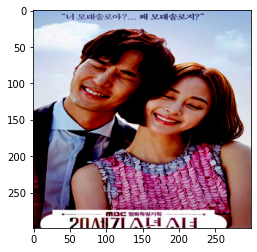

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(x.permute(1,2,0))
print(y)

# print(dataset.vocab.itos[1])

for i in y:
    print(dataset.vocab.itos[int(i)],end=" ")

In [ ]:
def save_checkpoint(state, filename = "my_checkpoint.pth.tar"):
    print("saving checkpoint!")
    torch.save(state, filename)

In [ ]:
def load_checkpoint(checkpoint, model, optimizer):
    print("loading checkpoint!")
    model.load_state_dict(checkpoint["state_dict"])
    model.load_state_optimizer(checkpoint["optimizer"])
    step = checkpoint["step"]
    return step

In [ ]:
from tqdm import tqdm
torch.backends.cudnn.benchmark = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
load_model = False
save_model=False
train_CNN = False

In [ ]:
# model = CNN2RNN(embed_size=embed_size, hidden_size=hidden_size,vocab_size=vocab_size, num_layers=num_layers).to(device=device)

In [ ]:
import torch.optim as optim 

step = 0
embed_size = 256
hidden_size = 256
num_layers = 5
num_epochs = 5
learning_rate = 3e-4
vocab_size = len(dataset.vocab)

In [ ]:
model = CNN2RNN(embed_size=embed_size, hidden_size=hidden_size,vocab_size=vocab_size, num_layers=num_layers).to(device=device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model.decoderRNN

decoderRNN(
  (embedding): Embedding(2550, 256)
  (lstm): LSTM(256, 256, num_layers=5)
  (linear): Linear(in_features=256, out_features=2550, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
loss_criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr = learning_rate)


In [ ]:
if load_model:
    step = load_checkpoint(torch.load("my_checkpoint.pth.tar"), model, optimizer)

In [ ]:
model.train()

for epoch in range(num_epochs):
    if save_model:
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": model.state_dict(),
            "step": step,
        }
        save_checkpoint(checkpoint)

#     for idx, (imgs, captions) in tqdm(
#         enumerate(loader), total=len(loader), leave=False
#     ):
    for idx, (imgs, captions) in enumerate(loader):
        imgs = imgs.to(device)
        captions = captions.to(device)
        
        score = model(imgs, captions[:-1])
        
#         print(score.shape, captions.shape)
#         print(score.reshape(-1, score.shape[2]).shape, captions.reshape(-1).shape)
#         print("why are we reshaping it here?")
        optimizer.zero_grad()
        loss = loss_criterion(score.reshape(-1, score.shape[2]), captions.reshape(-1))
        
       
        step += 1
        
        loss.backward()
        optimizer.step()
    print(f"Loss for epoch {epoch}: {loss}")

Loss for epoch 0: 7.792633533477783
Loss for epoch 1: 7.650053024291992
Loss for epoch 2: 6.64125919342041
Loss for epoch 3: 5.2179059982299805
Loss for epoch 4: 3.9942121505737305


In [ ]:
image_path = img_folder + "299.jpg"

img = Image.open(image_path).convert("RGB")

img = transform(img)

# plt.imshow(img.permute(1,2,0))

image_input = img.to(device=device) # check here
image_input = image_input.unsqueeze(0)
print(image_input.shape)

model.eval()
# model.encoderCNN(image_input)
# dataset.vocab
print(model.captionImage(image=image_input, vocabulary=dataset.vocab))

torch.Size([1, 3, 299, 299])
tensor([-0.0081, -0.0062,  0.0440,  ..., -0.0104,  0.0325,  0.0396])


IndexError: ignored

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.models as models
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T


In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        

    def forward(self, images):
        features = self.resnet(images)                                    #(batch_size,2048,7,7)
        features = features.permute(0, 2, 3, 1)                           #(batch_size,7,7,2048)
        features = features.view(features.size(0), -1, features.size(-1)) #(batch_size,49,2048)
        return features

In [ ]:
class Attention(nn.Module):
    def __init__(self, encoder_dim,decoder_dim,attention_dim):
        super(Attention, self).__init__()
        
        self.attention_dim = attention_dim
        
        self.W = nn.Linear(decoder_dim,attention_dim)
        self.U = nn.Linear(encoder_dim,attention_dim)
        
        self.A = nn.Linear(attention_dim,1)
        
        
        
        
    def forward(self, features, hidden_state):
        u_hs = self.U(features)     #(batch_size,num_layers,attention_dim)
        w_ah = self.W(hidden_state) #(batch_size,attention_dim)
        
        combined_states = torch.tanh(u_hs + w_ah.unsqueeze(1)) #(batch_size,num_layers,attemtion_dim)
        
        attention_scores = self.A(combined_states)         #(batch_size,num_layers,1)
        attention_scores = attention_scores.squeeze(2)     #(batch_size,num_layers)
        
        
        alpha = F.softmax(attention_scores,dim=1)          #(batch_size,num_layers)
        
        attention_weights = features * alpha.unsqueeze(2)  #(batch_size,num_layers,features_dim)
        attention_weights = attention_weights.sum(dim=1)   #(batch_size,num_layers)
        
        return alpha,attention_weights

In [ ]:
#Attention Decoder
class DecoderRNN(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        
        #save the model param
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.attention = Attention(encoder_dim,decoder_dim,attention_dim)
        
        
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  
        self.lstm_cell = nn.LSTMCell(embed_size+encoder_dim,decoder_dim,bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        
        
        self.fcn = nn.Linear(decoder_dim,vocab_size)
        self.drop = nn.Dropout(drop_prob)
        
        
    
    def forward(self, features, captions):
        
        #vectorize the caption
        embeds = self.embedding(captions)
        
        # Initialize LSTM state
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        #get the seq length to iterate
        seq_length = len(captions[0])-1 #Exclude the last one
        batch_size = captions.size(0)
        num_features = features.size(1)
        
        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length,num_features).to(device)
                
        for s in range(seq_length):
            alpha,context = self.attention(features, h)
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
                    
            output = self.fcn(self.drop(h))
            
            preds[:,s] = output
            alphas[:,s] = alpha  
        
        
        return preds, alphas
    
    def generate_caption(self,features,max_len=20,vocab=None):
        # Inference part
        # Given the image features generate the captions
        
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        alphas = []
        
        #starting input
        word = torch.tensor(vocab.stoi['<SOS>']).view(1,-1).to(device)
        embeds = self.embedding(word)

        
        captions = []
        
        for i in range(max_len):
            alpha,context = self.attention(features, h)
            
            
            #store the apla score
            alphas.append(alpha.cpu().detach().numpy())
            
            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size,-1)
        
            
            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)
            
            #save the generated word
            captions.append(predicted_word_idx.item())
            
            #end if <EOS detected>
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break
            
            #send generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))
        
        #covert the vocab idx to words and return sentence
        return [vocab.itos[idx] for idx in captions],alphas
    
    
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c

In [ ]:
class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderCNN()
        self.decoder = DecoderRNN(
            embed_size=embed_size,
            vocab_size = len(dataset.vocab),
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )
        
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

In [ ]:
embed_size=300
vocab_size = len(dataset.vocab)
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 3e-4

In [ ]:
#init model
model = EncoderDecoder(
    embed_size=300,
    vocab_size = len(dataset.vocab),
    attention_dim=256,
    encoder_dim=2048,
    decoder_dim=512
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
#helper function to save the model
def save_model(model,num_epochs):
    model_state = {
        'num_epochs':num_epochs,
        'embed_size':embed_size,
        'vocab_size':len(dataset.vocab),
        'attention_dim':attention_dim,
        'encoder_dim':encoder_dim,
        'decoder_dim':decoder_dim,
        'state_dict':model.state_dict()
    }

    torch.save(model_state,'attention_model_state.pth')

In [ ]:
num_epochs = 25
print_every = 100

# loader, dataset = get_loader()

for epoch in range(1,num_epochs+1):   
    for idx, (image, captions) in enumerate(iter(loader)):
        image,captions = image.to(device),captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs,attentions = model(image, captions)

        # Calculate the batch loss.
        targets = captions[:,1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        
        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()

        if (idx+1)%print_every == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))
            
            
            #generate the caption
            model.eval()
            with torch.no_grad():
                dataiter = iter(loader)
                img,_ = next(dataiter)
                features = model.encoder(img[0:1].to(device))
                caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
                caption = ' '.join(caps)
                # show_image(img[0],title=caption)
                
            model.train()
        
    #save the latest model
    save_model(model,epoch)

RuntimeError: ignored

In [ ]:
import matplotlib.pyplot as plt
def show_image(img, title=None):
    """Imshow for Tensor."""
    
    #unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated